In [2]:
# import pandas as pd
# import tarfile

# with tarfile.open(name='../raw_data/zelle.tar') as tf:
#     tarinfo = tf.getmember('4.jpg')
#     image = tf.extractfile(tarinfo)
#     image = image.read()
#     image = image.open(io.BytesIO(image))

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img=mpimg.imread('../raw_data/zelle/4.jpg')

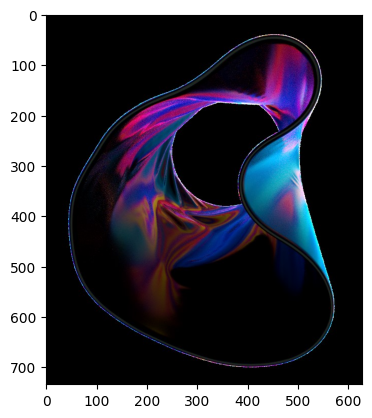

In [4]:
plt.imshow(img)

In [5]:
import os


def load_images_from_folder(foldername):
    images = []
    for filename in os.listdir(foldername):
        img=mpimg.imread(os.path.join(foldername,filename))
        if img is not None:
            images.append(img)
    return images


In [6]:
imgs = load_images_from_folder('../raw_data/subset_test')

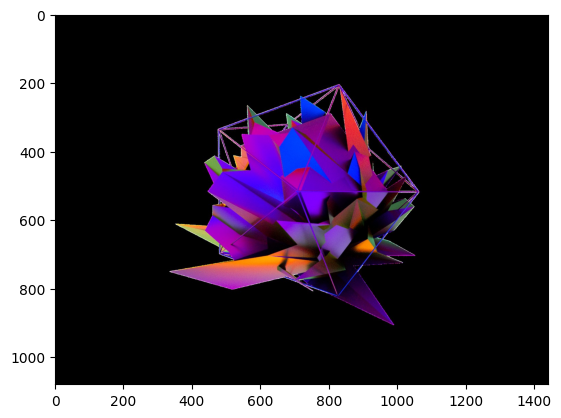

In [7]:
plt.imshow(imgs[1])

In [8]:
len(imgs)

36

In [9]:
imgs[0].shape

(1080, 1440, 3)

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np


X_train = (np.array(imgs[12:])) / 255.
X_test = (np.array(imgs[:12])) / 255.

def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Conv2D(8, (2,2), input_shape=(1080, 1440, 3), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(16, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(32, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))     

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

In [19]:
encoder = build_encoder(latent_dimension=2)

In [20]:

from tensorflow.keras.layers import Reshape, Conv2DTranspose
def build_decoder(latent_dimension):
    # $CHALLENGIFY_BEGIN
    decoder = Sequential()
    decoder.add(Dense(7*7*8, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((7, 7, 8)))  # no batch axis here
    decoder.add(Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(1, (2, 2), strides=2, padding='same', activation='relu'))
    return decoder

In [21]:
decoder = build_decoder(2)

In [22]:
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 392)               1176      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 8)           0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 8)        264       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 1)        33        
 ranspose)                                                       
                                                                 
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


In [23]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1079, 1439, 8)     104       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 539, 719, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 538, 718, 16)      528       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 269, 359, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 268, 358, 32)      2080      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 134, 179, 32)    

In [24]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_autoencoder(encoder, decoder):
    inp = Input((1080, 1440, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

In [25]:
autoencoder = build_autoencoder(encoder, decoder)

In [26]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1080, 1440, 3)]   0         
                                                                 
 sequential_2 (Sequential)   (None, 2)                 1537818   
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         1473      
                                                                 
Total params: 1,539,291
Trainable params: 1,539,291
Non-trainable params: 0
_________________________________________________________________


In [27]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

In [28]:
compile_autoencoder(autoencoder)

In [30]:
autoencoder.fit(X_train, X_train)

ValueError: in user code:

    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/sophiabouchama/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 28 and 1080 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model/sequential_3/conv2d_transpose_3/Relu, IteratorGetNext:1)' with input shapes: [?,28,28,1], [?,1080,1440,3].
